# Sentiment Analysis in Python

We will be doing some sentiment analysis in python using two different techniques:
1. VADER (Valence Aware Dictionary and sEntiment Reasoner) - Bag of words approach
2. Roberta Pretrained Model from 🤗

# Step 0. Read in Data and NLTK Basics

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use('ggplot')

import nltk

In [2]:
# Read in data
df = pd.read_csv('Netflix Engagemen.csv')
print(df.shape)
df = df.head(500)
print(df.shape)

(18332, 9)
(500, 9)


In [3]:
df.head()

,Title,Available Globally?,Release Date,Hours Viewed,Number of Ratings,Rating,Genre,Key Words,Description
0,The Night Agent: Season 1,Yes,2023-03-23,812100000,7696.0,6.0,"['Biography', 'Drama', 'History']","persian empire,empire,5th century b.c.,achaeme...",NaN
1,Ginny & Georgia: Season 2,Yes,2023-01-05,665100000,5216.0,5.7,"['Comedy', 'Drama', 'Romance']","producer,three word title,headstrong,arranged ...",The film follows headstrong Ginny who meets Su...
2,The Glory: Season 1 // 더 글로리: 시즌 1,Yes,2022-12-30,622800000,11869.0,8.4,['Short'],NaN,NaN
3,Wednesday: Season 1,Yes,2022-11-23,507700000,NaN,NaN,['Talk-Show'],youtube video,MsMojo counts down the top 10 Wednesday (2022)...
4,Queen Charlotte: A Bridgerton Story,Yes,2023-05-04,503000000,50077.0,7.4,"['Drama', 'History', 'Romance']","prequel,queen,historical,england,queen charlot...","Betrothed against her will to King George, you..."


## Quick EDA

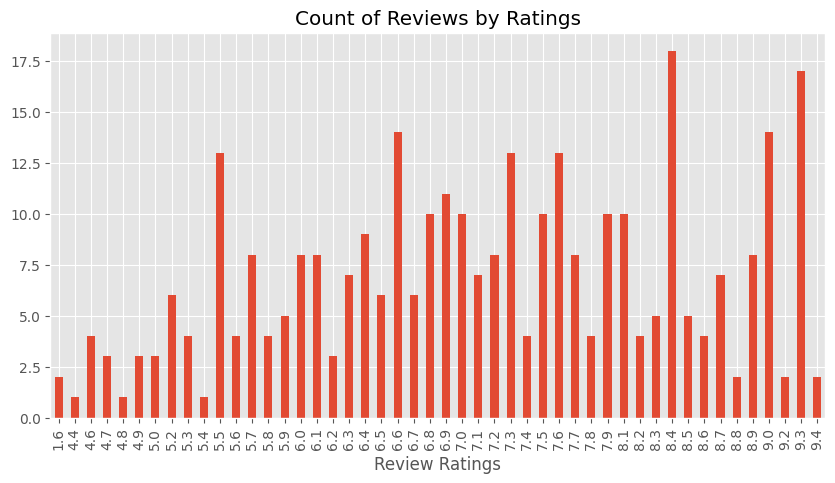

In [4]:
# score ki jagha rating kiya
ax = df['Rating'].value_counts().sort_index() \
    .plot(kind='bar',
          title='Count of Reviews by Ratings',
          figsize=(10, 5))
ax.set_xlabel('Review Ratings')
plt.show()

## Basic NLTK

In [5]:
example = df['Description'][50]    
print(example)

nan


In [6]:
import nltk
nltk.download('punkt')


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\aurav\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [7]:
example = str(example)  # Convert to string if not already
tokens = nltk.word_tokenize(example)
print(tokens[:10])


if example is None or pd.isna(example):
    example = ""  # Replace None/NaN with an empty string
tokens = nltk.word_tokenize(example)
print(tokens[:10])


['nan']
['nan']


In [8]:
tokens = nltk.word_tokenize(example)
tokens[:10]

['nan']

In [9]:
import nltk
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\aurav\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

In [10]:
tagged = nltk.pos_tag(tokens)
tagged[:10]

[('nan', 'NN')]

In [11]:
import nltk
nltk.download('maxent_ne_chunker')
nltk.download('words')  # Additional dependency for ne_chunk


[nltk_data] Downloading package maxent_ne_chunker to
[nltk_data]     C:\Users\aurav\AppData\Roaming\nltk_data...
[nltk_data]   Package maxent_ne_chunker is already up-to-date!
[nltk_data] Downloading package words to
[nltk_data]     C:\Users\aurav\AppData\Roaming\nltk_data...
[nltk_data]   Package words is already up-to-date!


True

In [12]:
entities = nltk.chunk.ne_chunk(tagged)
entities.pprint()

(S nan/NN)


# Step 1. VADER Seniment Scoring

We will use NLTK's `SentimentIntensityAnalyzer` to get the neg/neu/pos scores of the text.

- This uses a "bag of words" approach:
    1. Stop words are removed
    2. each word is scored and combined to a total score.

In [13]:
import nltk
nltk.download('vader_lexicon')

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\aurav\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

In [14]:
from nltk.sentiment import SentimentIntensityAnalyzer
from tqdm.notebook import tqdm

sia = SentimentIntensityAnalyzer()

In [15]:
sia.polarity_scores('I am so happy!')

{'neg': 0.0, 'neu': 0.318, 'pos': 0.682, 'compound': 0.6468}

In [16]:
sia.polarity_scores('This is the worst thing ever.')

{'neg': 0.451, 'neu': 0.549, 'pos': 0.0, 'compound': -0.6249}

In [17]:
sia.polarity_scores(example)

{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}

In [18]:
from tqdm import tqdm

res = {}
for i, row in tqdm(df.iterrows(), total=len(df)):
    text = row['Description']
    myid = row['Title']
    
    if isinstance(text, str):  # Process only if it's a string
        res[myid] = sia.polarity_scores(text)




100%|██████████| 500/500 [00:00<00:00, 7932.79it/s]


In [19]:
vaders = pd.DataFrame(res).T
vaders = vaders.reset_index().rename(columns={'index': 'Title'})
vaders = vaders.merge(df, how='left')

In [20]:
# Now we have sentiment score and metadata
vaders.head()

,Title,neg,neu,pos,compound,Available Globally?,Release Date,Hours Viewed,Number of Ratings,Rating,Genre,Key Words,Description
0,Ginny & Georgia: Season 2,0.0,0.610,0.390,0.9559,Yes,2023-01-05,665100000,5216.0,5.7,"['Comedy', 'Drama', 'Romance']","producer,three word title,headstrong,arranged ...",The film follows headstrong Ginny who meets Su...
1,Wednesday: Season 1,0.0,0.847,0.153,0.2023,Yes,2022-11-23,507700000,NaN,NaN,['Talk-Show'],youtube video,MsMojo counts down the top 10 Wednesday (2022)...
2,Queen Charlotte: A Bridgerton Story,0.0,1.000,0.000,0.0000,Yes,2023-05-04,503000000,50077.0,7.4,"['Drama', 'History', 'Romance']","prequel,queen,historical,england,queen charlot...","Betrothed against her will to King George, you..."
3,You: Season 4,0.0,0.531,0.469,0.9410,Yes,2023-02-09,440600000,45624.0,6.6,"['Comedy', 'Romance']","christmas,coming out,holidays,lesbian relation...",A holiday romantic comedy that captures the ra...
4,Ginny & Georgia: Season 1,0.0,0.610,0.390,0.9559,Yes,2021-02-24,302100000,5216.0,5.7,"['Comedy', 'Drama', 'Romance']","producer,three word title,headstrong,arranged ...",The film follows headstrong Ginny who meets Su...


## Plot VADER results

In [ ]:
# ax = sns.barplot(data=vaders, x='Rating', y='compound')
# ax.set_title('Compund Score by Netflix shows Review')
# plt.show() 

Index(['Title', 'neg', 'neu', 'pos', 'compound', 'Available Globally?',
       'Release Date', 'Hours Viewed', 'Number of Ratings', 'Rating', 'Genre',
       'Key Words', 'Description'],
      dtype='object')
                                 Title Available Globally? Release Date  \
0            The Night Agent: Season 1                 Yes   2023-03-23   
1            Ginny & Georgia: Season 2                 Yes   2023-01-05   
2   The Glory: Season 1 // 더 글로리: 시즌 1                 Yes   2022-12-30   
3                  Wednesday: Season 1                 Yes   2022-11-23   
4  Queen Charlotte: A Bridgerton Story                 Yes   2023-05-04   

   Hours Viewed  Number of Ratings  Rating                              Genre  \
0     812100000             7696.0     6.0  ['Biography', 'Drama', 'History']   
1     665100000             5216.0     5.7     ['Comedy', 'Drama', 'Romance']   
2     622800000            11869.0     8.4                          ['Short']   
3     507700000 

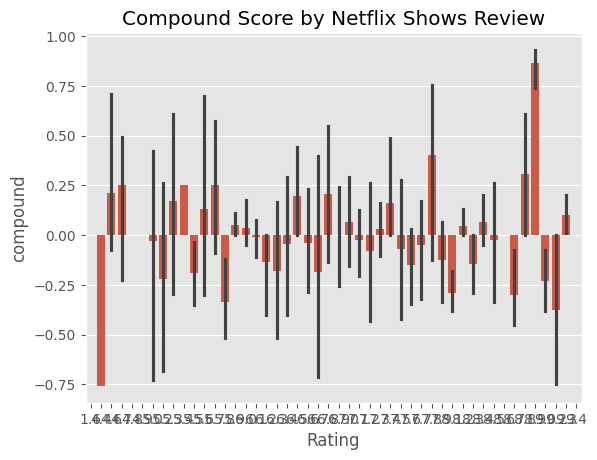

In [21]:
print(vaders.columns)


# Initialize the SentimentIntensityAnalyzer
from nltk.sentiment import SentimentIntensityAnalyzer
sia = SentimentIntensityAnalyzer()

# Assuming 'df' is your DataFrame containing the 'Description' column
# Create a new column to store the sentiment scores
df['Sentiment'] = df['Description'].apply(lambda x: sia.polarity_scores(str(x)))

# Extract the compound score and add it as a new column
df['compound'] = df['Sentiment'].apply(lambda x: x['compound'])

# Check if the 'compound' column is now present
print(df.head())

# Now you can plot the data using Seaborn
ax = sns.barplot(data=df, x='Rating', y='compound')
ax.set_title('Compound Score by Netflix Shows Review')
plt.show()



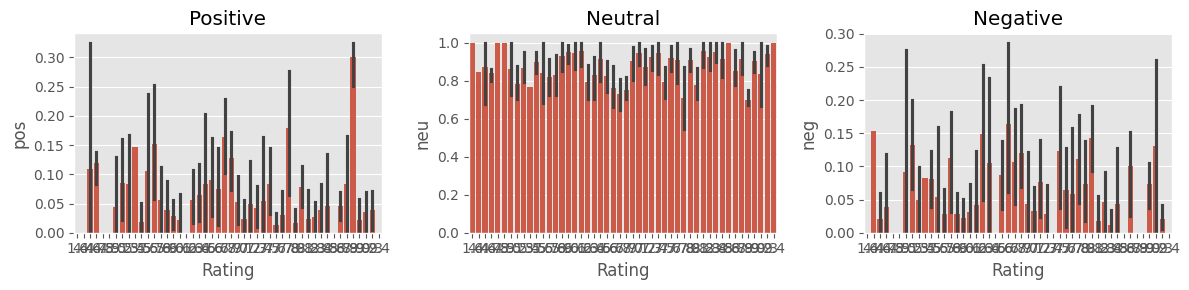

In [22]:
# Assuming 'df' is your original DataFrame
from nltk.sentiment import SentimentIntensityAnalyzer
import matplotlib.pyplot as plt
import seaborn as sns

# Initialize SentimentIntensityAnalyzer
sia = SentimentIntensityAnalyzer()

# Calculate the polarity scores and create new columns for each sentiment component
df['Sentiment'] = df['Description'].apply(lambda x: sia.polarity_scores(str(x)))

# Extract individual sentiment scores
df['pos'] = df['Sentiment'].apply(lambda x: x['pos'])
df['neu'] = df['Sentiment'].apply(lambda x: x['neu'])
df['neg'] = df['Sentiment'].apply(lambda x: x['neg'])

# Now create the plots
fig, axs = plt.subplots(1, 3, figsize=(12, 3))

# Create the barplots
sns.barplot(data=df, x='Rating', y='pos', ax=axs[0])
sns.barplot(data=df, x='Rating', y='neu', ax=axs[1])
sns.barplot(data=df, x='Rating', y='neg', ax=axs[2])

# Set titles for each subplot
axs[0].set_title('Positive')
axs[1].set_title('Neutral')
axs[2].set_title('Negative')

# Adjust layout and show the plot
plt.tight_layout()
plt.show()


In [ ]:
# fig, axs = plt.subplots(1, 3, figsize=(12, 3))
# sns.barplot(data=vaders, x='Rating', y='pos', ax=axs[0])
# sns.barplot(data=vaders, x='Rating', y='neu', ax=axs[1])
# sns.barplot(data=vaders, x='Rating', y='neg', ax=axs[2])
# axs[0].set_title('Positive')
# axs[1].set_title('Neutral')
# axs[2].set_title('Negative')
# plt.tight_layout()
# plt.show()

# Step 3. Roberta Pretrained Model

- Use a model trained of a large corpus of data.
- Transformer model accounts for the words but also the context related to other words.

In [23]:
from transformers import AutoTokenizer
from transformers import AutoModelForSequenceClassification
from scipy.special import softmax

c:\Users\aurav\AppData\Local\Programs\Python\Python311\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [24]:
MODEL = f"cardiffnlp/twitter-roberta-base-sentiment"
tokenizer = AutoTokenizer.from_pretrained(MODEL)
model = AutoModelForSequenceClassification.from_pretrained(MODEL)

In [25]:
# VADER results on example
print(example)
sia.polarity_scores(example)

nan


{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}

In [26]:
# Run for Roberta Model
encoded_text = tokenizer(example, return_tensors='pt')
output = model(**encoded_text)
scores = output[0][0].detach().numpy()
scores = softmax(scores)
scores_dict = {
    'roberta_neg' : scores[0],
    'roberta_neu' : scores[1],
    'roberta_pos' : scores[2]
}
print(scores_dict)

{'roberta_neg': 0.2395022, 'roberta_neu': 0.5281888, 'roberta_pos': 0.232309}


In [28]:
def polarity_scores_roberta(example):
    encoded_text = tokenizer(example, return_tensors='pt')
    output = model(**encoded_text)
    scores = output[0][0].detach().numpy()
    scores = softmax(scores)
    scores_dict = {
        'roberta_neg' : scores[0],
        'roberta_neu' : scores[1],
        'roberta_pos' : scores[2]
    }
    return scores_dict

In [29]:
res = {}
for i, row in tqdm(df.iterrows(), total=len(df)):
    try:
        # Convert the 'Description' column to a string to avoid issues with floats
        text = str(row['Description'])  # Ensure the text is a string
        myid = row['Title']
        
        # VADER Sentiment Analysis
        vader_result = sia.polarity_scores(text)
        vader_result_rename = {}
        for key, value in vader_result.items():
            vader_result_rename[f"vader_{key}"] = value
        
        # Example of a custom Roberta sentiment analysis function
        roberta_result = polarity_scores_roberta(text)
        
        # Combine results from both models
        both = {**vader_result_rename, **roberta_result}
        
        # Store the combined results in the 'res' dictionary using the 'Title' as the key
        res[myid] = both
    except RuntimeError:
        print(f'Broke for id {myid}')


100%|██████████| 500/500 [00:41<00:00, 12.17it/s]


In [30]:
results_df = pd.DataFrame(res).T
results_df = results_df.reset_index().rename(columns={'index': 'Title'})
results_df = results_df.merge(df, how='left')

## Compare Scores between models

In [31]:
results_df.columns

Index(['Title', 'vader_neg', 'vader_neu', 'vader_pos', 'vader_compound',
       'roberta_neg', 'roberta_neu', 'roberta_pos', 'Available Globally?',
       'Release Date', 'Hours Viewed', 'Number of Ratings', 'Rating', 'Genre',
       'Key Words', 'Description', 'Sentiment', 'compound', 'pos', 'neu',
       'neg'],
      dtype='object')

# Step 3. Combine and compare

c:\Users\aurav\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\axisgrid.py:123: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


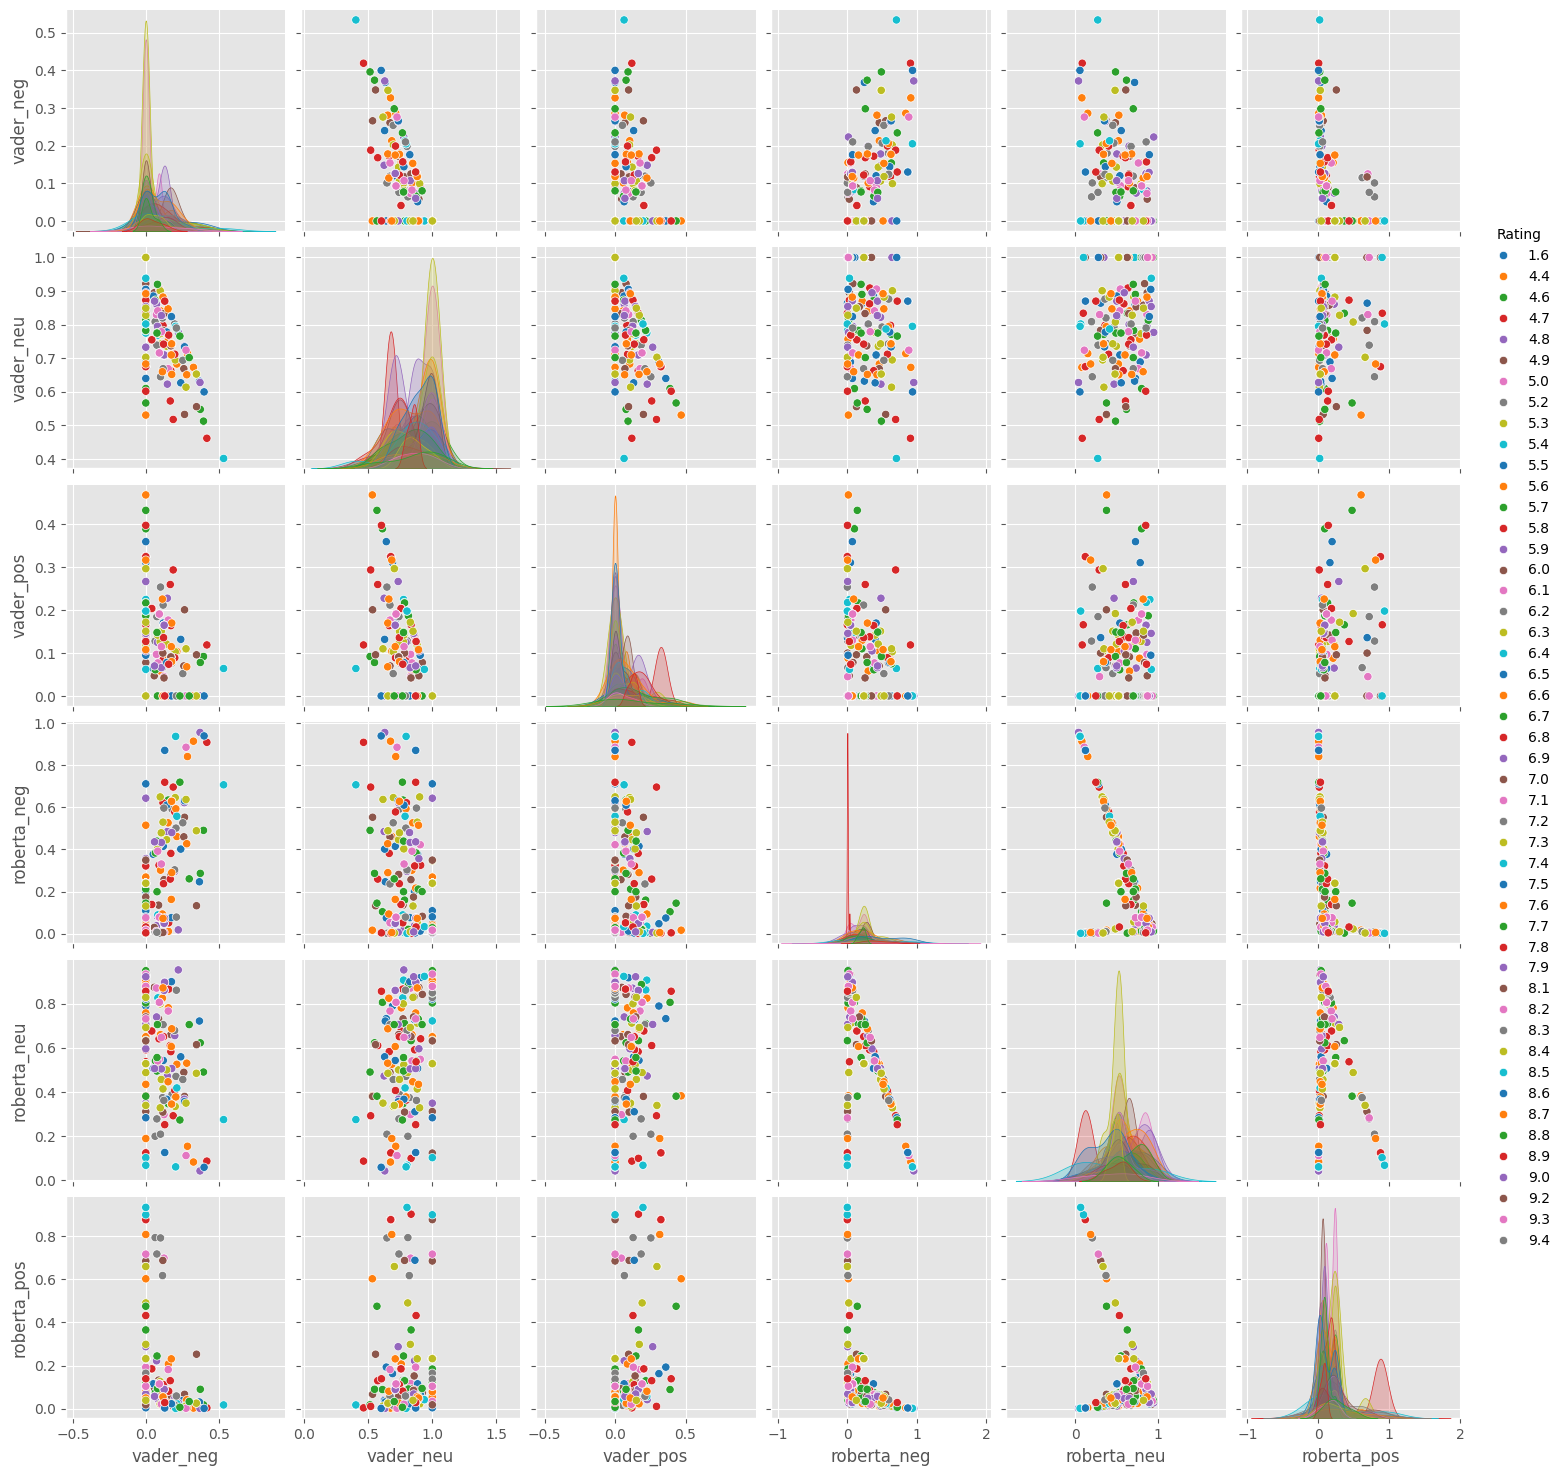

In [32]:
sns.pairplot(data=results_df,
             vars=['vader_neg', 'vader_neu', 'vader_pos',
                  'roberta_neg', 'roberta_neu', 'roberta_pos'],
            hue='Rating',
            palette='tab10')
plt.show()

# Step 4: Review Examples:

- Positive 1-Star and Negative 10-Star Reviews

- Some examples where the model scoring and review score differ the most.

In [33]:
results_df.query('Rating == 4.4') \
    .sort_values('roberta_pos', ascending=False)['Description'].values[0]


# # Filter for rows where Rating is 1
# filtered_df = results_df.query('Rating == 1')

# # Check if the filtered DataFrame is not empty
# if not filtered_df.empty:
#     # Sort by roberta_pos and get the Description of the first row
#     description = filtered_df.sort_values('roberta_pos', ascending=False)['Description'].values[0]
#     print(description)
# else:
#     print("No rows found with Rating == 1")



'It&apos;s 1940&apos;s Australia and siblings Maggie and Charles must endure taunts of newly enlisted teenagers, grapple with the fact that neither of them can fight in the war and resort to chess in order to pass the time.'

In [34]:
# results_df.Rating
print(results_df['Rating'].value_counts())

Rating
8.4    18
9.3    17
9.0    14
6.6    14
5.5    13
7.3    13
7.6    13
6.9    11
6.8    10
8.1    10
7.0    10
7.5    10
7.9    10
6.4     9
7.2     8
6.1     8
5.7     8
6.0     8
7.7     8
8.9     8
7.1     7
6.3     7
8.7     7
6.5     6
5.2     6
6.7     6
5.9     5
8.3     5
8.5     5
8.6     4
5.3     4
7.8     4
5.6     4
4.6     4
7.4     4
5.8     4
8.2     4
5.0     3
4.9     3
4.7     3
6.2     3
1.6     2
9.2     2
9.4     2
8.8     2
5.4     1
4.8     1
4.4     1
Name: count, dtype: int64


In [38]:
results_df.query('Rating == 4.4') \
    .sort_values('vader_pos', ascending=False)['Description'].values[0]

'It&apos;s 1940&apos;s Australia and siblings Maggie and Charles must endure taunts of newly enlisted teenagers, grapple with the fact that neither of them can fight in the war and resort to chess in order to pass the time.'

#### nevative sentiment 10-Star view

In [36]:
results_df.query('Rating == 9.3') \
    .sort_values('roberta_neg', ascending=False)['Description'].values[0]

'We found a need to normalize the phase of not being okay. There is a sense of having to be okay with a global pandemic, an international social movement, a change in our lifestyles, economies, friends, and family, and the constant...'

In [37]:
results_df.query('Rating == 9.3') \
    .sort_values('vader_neg', ascending=False)['Description'].values[0]

'In a war-torn world of elemental magic, a young boy reawakens to undertake a dangerous mystic quest to fulfill his destiny as the Avatar, and bring peace to the world.'